***IN PROGRESS***

**NY Red Bulls New-Transfer Pass-Network Analysis**

Created by Elijah Weston-Capulong on February 24, 2025, for the NY Red Bulls Data Science team.

This analysis will explore how recent European signing, Eric Maxim Chupo-Moting, could impact the New York Red Bulls' tactical outlay, setup, and performance through pass-network analysis.

In [1]:
# Import necessary libraries
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch, Sbopen
from NYRB import *
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
print('Libraries imported successfully')

Libraries imported successfully


In [2]:
# Open parser
parser = Sbopen()

# Global variable for Choupo-Moting's player ID
CHUPO_ID = 3499

In [3]:
# Load in the StatsBomb data for Choupo-Moting
selected_comps = load_competitions()
selected_comps

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,7,235,France,Ligue 1,male,False,False,2022/2023,2024-06-11T00:50:53.277411,2024-06-26T08:17:36.043856,2024-06-26T08:17:36.043856,2024-06-11T00:50:53.277411
3,7,108,France,Ligue 1,male,False,False,2021/2022,2024-06-03T16:46:00.665854,2024-06-03T16:49:55.355195,2024-06-03T16:49:55.355195,2024-06-03T16:46:00.665854
4,7,27,France,Ligue 1,male,False,False,2015/2016,2024-01-07T06:23:44.277971,None,None,2024-01-07T06:23:44.277971
5,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
6,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925
7,43,3,International,FIFA World Cup,male,False,True,2018,2024-06-12T07:38:19.345758,2021-06-13T16:17:31.694,None,2024-06-12T07:38:19.345758
8,43,55,International,FIFA World Cup,male,False,True,1990,2023-06-28T10:58:20.137929,2021-06-12T16:17:31.694,None,2023-06-28T10:58:20.137929
9,43,54,International,FIFA World Cup,male,False,True,1986,2023-12-26T22:34:04.263530,2021-06-13T16:17:31.694,None,2023-12-26T22:34:04.263530


First, I will examine his contributions to the Cameroon national team in the 2022 FIFA World Cup.

Here I make two dataframes:
1. cameroon_events_df includes all of Cameroon's match events throughout the entire World Cup. 
2. cameroon_serbia_events_df includes all of Cameroon's match events in the match against Serbia (3-3). 

In [4]:
# Load events for all of Cameroons matches in the 2022 FIFA World Cup
cam_wc_match_ids = [3857259, 3857290, 3857280]
cameroon_events_df = load_events_for_matches(cam_wc_match_ids, team_filter='Cameroon')

# Load events for just Cameroon's match against Serbia
cam_serbia_match_id = 3857259
cameroon_serbia_events_df = load_events_for_matches([cam_serbia_match_id], team_filter='Cameroon')

Here I make two more dataframes:
1. cameroon_passes includes all of Cameroon's passes throughout the entire WC2022. 
2. cameroon_serbia_passes includes all of Cameroon's passes against Serbia specifically.

In [5]:
# Filter for passes on both dataframes
cameroon_passes = filter_passes(cameroon_events_df)
cameroon_serbia_passes = filter_passes(cameroon_serbia_events_df)

# Print cameroon_passes_serbia as an example
cameroon_serbia_passes

,player_name,x,y,end_x,end_y,pass_recipient_name,outcome_id,outcome_name,player_id,pass_recipient_id,minute
3,Ngoran Suiru Fai Collins,48.2,31.6,48.8,24.3,Martin Hongla Yma II,NaN,NaN,16346.0,30016.0,0
6,Martin Hongla Yma II,48.6,24.3,12.0,35.5,Devis Rogers Epassy Mboka,NaN,NaN,30016.0,15326.0,0
11,Devis Rogers Epassy Mboka,13.5,43.2,30.6,43.4,Martin Hongla Yma II,NaN,NaN,15326.0,30016.0,1
13,Martin Hongla Yma II,34.7,41.9,39.2,70.1,Jean-Charles Castelletto,NaN,NaN,30016.0,7426.0,1
15,Jean-Charles Castelletto,38.1,72.9,56.1,76.5,Ngoran Suiru Fai Collins,NaN,NaN,7426.0,16346.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1357,Devis Rogers Epassy Mboka,15.0,38.9,29.6,62.5,Ngoran Suiru Fai Collins,NaN,NaN,15326.0,16346.0,94
1364,Christian Mougang Bassogog,45.8,65.6,36.5,54.4,Jean-Charles Castelletto,NaN,NaN,46903.0,7426.0,95
1366,Jean-Charles Castelletto,36.5,54.4,39.3,66.3,Christian Mougang Bassogog,NaN,NaN,7426.0,46903.0,95
1373,Samuel Yves Oum Gwet,86.5,16.0,98.9,3.2,Georges-Kévin Nkoudou Mbida,NaN,NaN,8591.0,3639.0,95


Now that we have all of Cameroon's event data, we can begin to analyze how they play and how Chupo-Moting is invloved in their tactical scheme. These are the analyses I will do in order:
1. Create an individual Pass Network visualization for Cameroon's match against Serbia.
2. Create an aggregate Pass Network visualization for Cameroon's three 2022 FIFA World Cup games.

Task 1: Visualizations for Cameroon vs. Serbia (3-3), 2022 FIFA World Cup Group Stage:

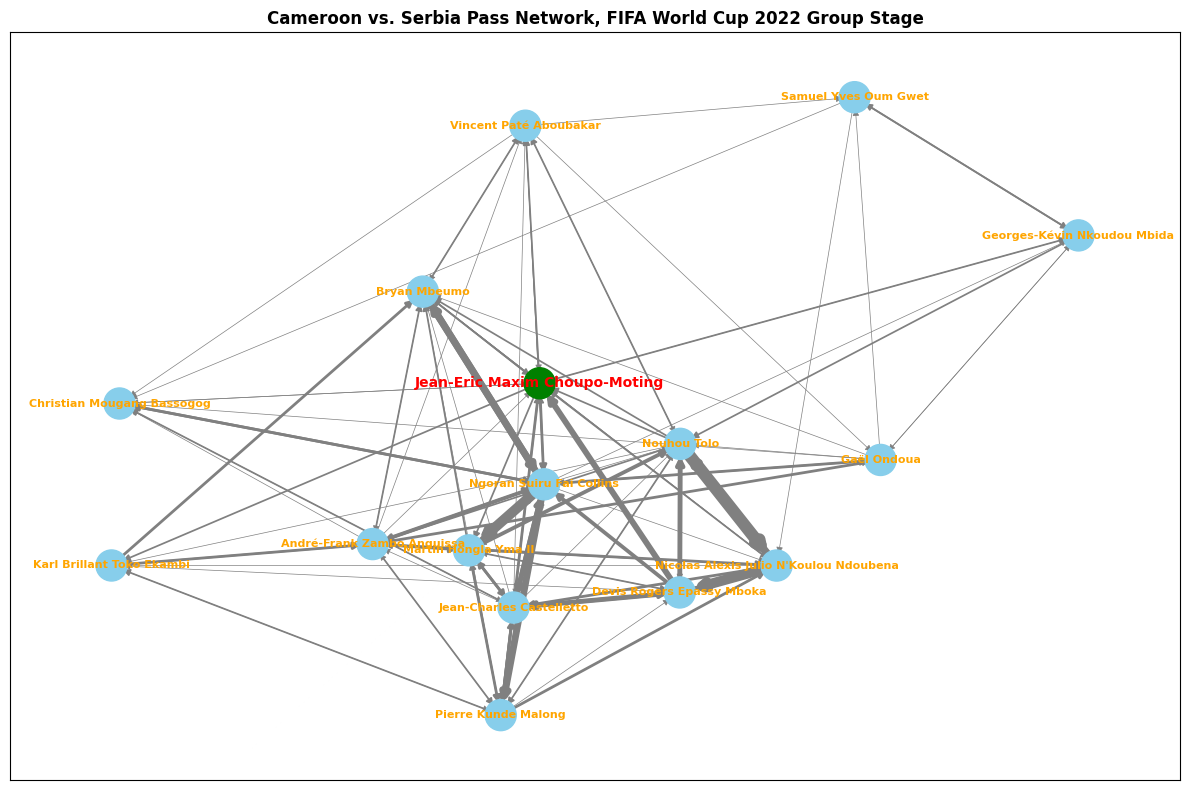

In [6]:
# Create individual pass networks for Cameroon vs. Serbia.
cameroon_serbia_pass_network = create_pass_network(cameroon_serbia_passes)

# Now call the function to plot the network, highlighting Choupo-Moting.
plot_pass_network_highlight(
    cameroon_serbia_pass_network,
    highlight_player='Jean-Eric Maxim Choupo-Moting',
    title='Cameroon vs. Serbia Pass Network, FIFA World Cup 2022 Group Stage'
)

In this graph, each edge weight represents the number of successful passes made from one player (the source node) to another (the target node). Every time a successful pass occurs between two players, the weight on the corresponding edge is incremented, effectively capturing the frequency of passing interactions between them. In this graph, Chupo-Moting is represented by the green node with the red label.

In order to gain insight into the importance of each player to Cameroon's pass network against Serbia, we compute each node's in-degree, out-degree, and degree centrality. In-degree is defined as the number of incoming edges a node has. Out-degree is defined as the number of outgoing edges a node has. Therefore, the players who have sent and received the most passes will have the highest in-degrees and out-degrees, respectively.

Degree centrality is defined as the proportion of nodes a given node is connected to in the network. In this context, a player with high degree centrality is one who is directly involved with a large number of other players, either by making or receiving passes, indicating their central role in the team's passing structure.

Here are the calculated values:

In [7]:
# Get in-degree, out-degree, and degree centrality for all players in the network
calculate_degrees(G=cameroon_serbia_pass_network)

In-Degree:
1. Player: Bryan Mbeumo: 11
2. Player: Ngoran Suiru Fai Collins: 10
3. Player: Nicolas Alexis Julio N'Koulou Ndoubena: 10
4. Player: Jean-Eric Maxim Choupo-Moting: 10
5. Player: Nouhou Tolo: 9
6. Player: André-Frank Zambo Anguissa: 9
7. Player: Martin Hongla Yma II: 8
8. Player: Jean-Charles Castelletto: 7
9. Player: Christian Mougang Bassogog: 7
10. Player: Pierre Kunde Malong: 7
11. Player: Vincent Paté Aboubakar: 6
12. Player: Karl Brillant Toko Ekambi: 6
13. Player: Devis Rogers Epassy Mboka: 5
14. Player: Gaël Ondoua: 4
15. Player: Georges-Kévin Nkoudou Mbida: 4
16. Player: Samuel Yves Oum Gwet: 3

Out-Degree:
1. Player: Ngoran Suiru Fai Collins: 12
2. Player: Jean-Charles Castelletto: 11
3. Player: André-Frank Zambo Anguissa: 10
4. Player: Jean-Eric Maxim Choupo-Moting: 10
5. Player: Pierre Kunde Malong: 9
6. Player: Nouhou Tolo: 9
7. Player: Nicolas Alexis Julio N'Koulou Ndoubena: 8
8. Player: Martin Hongla Yma II: 8
9. Player: Devis Rogers Epassy Mboka: 7
10. Player:

These results reveal early indications of Chupo-Moting's tactical role and importance in Cameroon's passing structure. Let's focus on Chupo-Moting and Bryan Mbuemo. Bryan Mbuemo is known as a creative player tasked with providing the "spark" in the final third, which is evident in his metrics. His in-degree is 11, the highest of any Cameroonian player in this match, meaning he received many passes. However, his out-degree is only 5, ranking 12th overall on the team. This indicates that he received many more completed passes than he made. The team relies on him to be an outlet in possession, granting him greater creative freedom with the ball. Although he may lose the ball several times—evidenced by the large discrepancy between passes received and sent—the team depends on his ability to produce that one "moment of magic" to win the game. As a result, Bryan Mbuemo's degree centrality is relatively low (9th on the team), suggesting that while he may not be the most crucial connector in the pass network, he is essential for creating the final actions of a play.

Chupo-Moting is a very different player. Both his in-degree and out-degree are 10, ranking 4th on the team in both categories. For every successful pass he received, Chupo-Moting made a successful pass. This indicates that he is far more central to Cameroon's build-up play, likely tasked with laying the ball off quickly to arriving midfielders or holding it up to allow Cameroon to settle further up the field. This is also evidenced by his high degree centrality; a value of 1.33 ranks second on the team. Cameroon clearly relies on Chupo-Moting's ball security and distribution to orchestrate their attacks.

Based on these early indications, I recommend that coaches utilize Chupo-Moting as a key distributor in build-up play—linking the midfield with the attack effectively and unlocking creative, dynamic players such as Mbuemo through his ability to maintain possession high up the field. Further analysis will be conducted to refine these suggestions and fully integrate his unique strengths into the team's tactical framework.

***

Now, instead of continuing to view the pass network in an abstract way, I will plot each player's average position and display corresponding visualizations.

In [8]:
# Get jersey data for Cameroon vs Serbia
cameroon_serbia_passes, cam_serbia_passer_locations = create_pass_network_datasets(cameroon_serbia_passes, cameroon_serbia_events_df, cam_serbia_match_id, subs_filter=False)
cameroon_serbia_passes.columns

Index(['player_name_x', 'x', 'y', 'end_x', 'end_y', 'pass_recipient_name',
       'outcome_id', 'outcome_name', 'player_id', 'pass_recipient_id',
       'minute', 'jersey_number', 'player_name_y', 'passer',
       'player_id_recipient', 'pass_recipient'],
      dtype='object')

In [9]:
cam_serbia_passer_locations

,x,y,count
passer,,,
3,32.470370,27.003704,27
5,65.120000,44.050000,10
7,89.016667,9.066667,6
8,68.700000,41.530000,20
10,79.171429,35.271429,7
11,96.040000,67.640000,5
12,85.028571,20.842857,7
13,70.842105,42.142105,19
14,75.375000,33.250000,4


Now that I have calculated the average passing postions for each player, I can plot it to visualize from where Chupo-Moting likes to pass. 

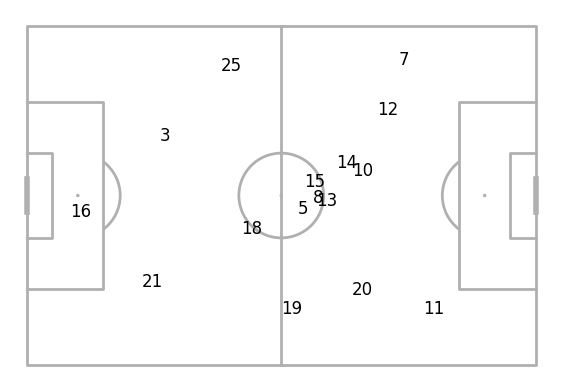

In [10]:
# Plot the average locations
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
pitch = Pitch(pitch_type='statsbomb')
pitch.draw(ax=ax)
for i, player in cam_serbia_passer_locations.iterrows():
    ax.text(player['x'], player['y'], i, color='black', fontsize=12, ha='center')
plt.show()

In analyzing Cameroon’s offensive setup, a few key observations about Chupo-Moting’s style of play emerge. The data shows that Chupo-Moting tends to drop significantly deeper to pass than the wide forwards around him, B. Mbuemo and K. Toko Ekambi. Mbuemo, a 25-year-old left-footed right-forward for Brentford in the Premier League, has a current season rating of 7.43 on WhoScored.com, ranking him 16th among players in the top 5 European leagues. This ranking, just ahead of players like Cole Palmer and Erling Haaland, highlights Mbuemo’s high level of attacking productivity. His output is driven by his direct style of play, technical excellence when needed, and a potent mix of pace and strength. Ekambi, a 32-year-old right-footed left-forward for Al-Ettifaq in the Saudi Pro League, is known for his pace, strength, and relentlessness, having been named La Liga Player of the Month with Villareal in October 2019. Ekambi, like Mbuemo, plays a tactical role in providing service to more lethal, central finishers who arrive late into the box. V. Aboubakar, a player with a similar profile to Mbuemo and Ekambi, was substituted in and made the penetrating runs that assisted Chupo-Moting’s goal in the 66th minute. Chupo-Moting, suited for a target-man role, stands out due to his technical ability, which makes him a great fit to unlock more explosive, creative players around him in exchange for providing them with chances. His passing patterns further confirm that he is adept at distributing the ball. I will delve deeper into this aspect of his play later in the analysis.

Chupo-Moting’s involvement in deeper positions also led to a Serbian goal. After picking up the ball deep in his own half, Chupo-Moting fired an incomplete 5-yard pass to a Cameroon CM. Faced with a Serbian, numerically-advantaged break, Cameroon committed a foul about 40 yards from goal. The resulting set piece was converted by Serbia just before halftime. This incident underscores the dual nature of Chupo-Moting’s playstyle—while his deeper movements are often intended to support buildup play, they also risk disrupting the team’s defensive balance. His hold-up and target-man style can be crucial in maintaining possession under pressure, but the turnover on this occasion led to a dangerous counterattack. 

Cameroon maintained a significant gap between defenders and midfielders, as shown in the chart. #18 Martin Hongla (CM) and #15 Pierre Kunde’s (CM) average positions were very far from the back line, meaning Cameroon wasn’t well set-up for losing the ball in central areas. Playing Chupo-Moting increases the likelihood of these types of ball losses due to his hold-up play being essential for advancing the ball up the field. When strikers receive these types of passes, their backs are often to goal and under intense pressure from center-backs or defensive midfielders who have tracked their movement. This creates a greater risk of turnovers, leaving the team vulnerable to counterattacks. 

Thus, if Chupo-Moting is to play, it’s crucial to ensure a well-structured safety net in midfield, helping to cover for these potential turnovers and balance the team defensively when the ball is lost. As the Red Bulls look to integrate Chupo-Moting into their squad, these passing networks and tactical patterns will be key in understanding how his movement and link-up play fit into their system. Further analysis of Cameroon’s passing networks during their World Cup run, and specifically in this game, follows.

In [11]:
# Create a passes dataframe using the number of rows per group as the pass count
pass_between = cameroon_serbia_passes.groupby(['passer', 'pass_recipient']).size().reset_index(name='pass_count')

# Check the resulting columns
pass_between

,passer,pass_recipient,pass_count
0,3,8,1
1,3,12,1
2,3,13,2
3,3,16,10
4,3,18,1
...,...,...,...
111,25,13,2
112,25,15,2
113,25,16,1
114,25,18,1


In [12]:
# Merge dataframes pass_between and average_locations
pass_between= pass_between.merge(cam_serbia_passer_locations,left_on='passer',right_index=True)
pass_between

,passer,pass_recipient,pass_count,x,y,count
0,3,8,1,32.47037,27.003704,27
1,3,12,1,32.47037,27.003704,27
2,3,13,2,32.47037,27.003704,27
3,3,16,10,32.47037,27.003704,27
4,3,18,1,32.47037,27.003704,27
...,...,...,...,...,...,...
111,25,13,2,48.16000,10.300000,25
112,25,15,2,48.16000,10.300000,25
113,25,16,1,48.16000,10.300000,25
114,25,18,1,48.16000,10.300000,25


In [13]:
# Add the average locations of the recipients
pass_between = pass_between.merge(cam_serbia_passer_locations, left_on='pass_recipient', right_index=True, suffixes=['', '_end'])
pass_between

,passer,pass_recipient,pass_count,x,y,count,x_end,y_end,count_end
0,3,8,1,32.47037,27.003704,27,68.700000,41.530000,20
1,3,12,1,32.47037,27.003704,27,85.028571,20.842857,7
2,3,13,2,32.47037,27.003704,27,70.842105,42.142105,19
3,3,16,10,32.47037,27.003704,27,12.684615,44.780769,26
4,3,18,1,32.47037,27.003704,27,52.990909,48.900000,22
...,...,...,...,...,...,...,...,...,...
111,25,13,2,48.16000,10.300000,25,70.842105,42.142105,19
112,25,15,2,48.16000,10.300000,25,67.811765,37.870588,17
113,25,16,1,48.16000,10.300000,25,12.684615,44.780769,26
114,25,18,1,48.16000,10.300000,25,52.990909,48.900000,22


Now that I have made the complete passes dataframe, I can create the visualization of Cameroon's Pass Network with the mplsoccer library.

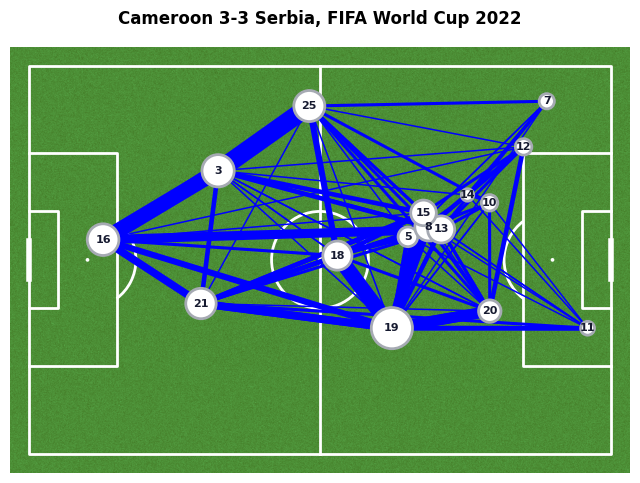

In [14]:
pitch = Pitch(pitch_color='grass', line_color='white')
# Set the figure size
fig, ax = pitch.draw(figsize=(8, 6), constrained_layout=True, tight_layout=False)

# Draw lines for filtered pass_between
pass_lines = pitch.lines(1.2 * pass_between.x, 0.8 * pass_between.y, 
                         1.2 * pass_between.x_end, 0.8 * pass_between.y_end, 
                         lw=pass_between.pass_count * 1.1, color='blue', zorder=1, ax=ax)

# Draw nodes
nodes = pitch.scatter(1.2 * cam_serbia_passer_locations.x, 0.8 * cam_serbia_passer_locations.y, 
                      s=20 * cam_serbia_passer_locations['count'].values, color='white', 
                      edgecolors='#a6aab3', linewidth=2, alpha=1, zorder=1, ax=ax)

# Annotate average_locations
for index, row in cam_serbia_passer_locations.iterrows():
    pitch.annotate(index, xy=(1.2 * row.x, 0.8 * row.y), c='#161A30', fontweight='bold', 
                   va='center', ha='center', size=8, ax=ax)

# Add the title
ax.set_title('Cameroon 3-3 Serbia, FIFA World Cup 2022', color='black', va='center', 
             ha='center', fontsize=12, fontweight='bold', pad=20, loc='center')

plt.show()

By identifying the nodes with the highest degree, we can determine which players on the Cameroon national team are most important to their passing patterns. The degree of a node is defined as the number of edges connecting that node to others. In this context, a higher node degree indicates that a player has a greater number of total receptions and passes.

From Cameroon's pass network against Serbia, it is clear that they play a direct brand of soccer. The goal-keeper, Devis Epassy, 

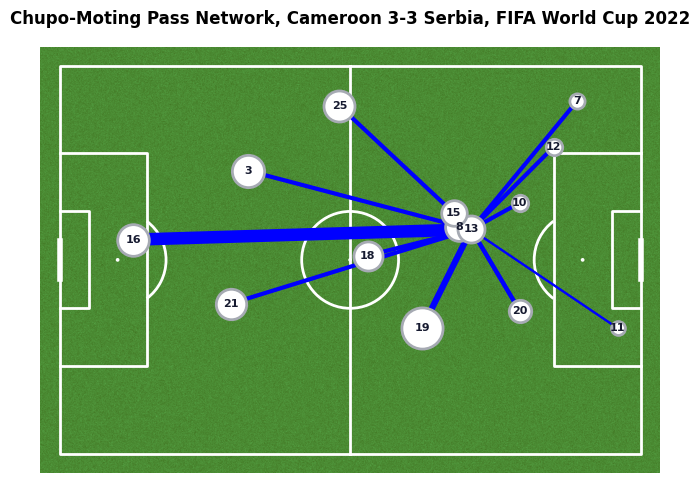

In [15]:
import pandas as pd

# Filter for Chupo-Moting's pass-betweens
chupo_pass_between = pass_between[(pass_between['passer'] == 13) | (pass_between['pass_recipient'] == 13)]

# Plot the average locations for Chupo-Moting's pass-betweens
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
pitch = Pitch(pitch_color='grass', line_color='white')
pitch.draw(ax=ax)

# Draw lines for Chupo-Moting's pass-betweens
pitch.lines(1.2 * chupo_pass_between.x, 0.8 * chupo_pass_between.y, 
            1.2 * chupo_pass_between.x_end, 0.8 * chupo_pass_between.y_end, 
            lw=chupo_pass_between.pass_count * 1.5, color='blue', zorder=1, ax=ax)

# Draw nodes for all players involved in Chupo-Moting's pass-betweens
involved_players = pd.concat([chupo_pass_between['passer'], chupo_pass_between['pass_recipient']]).unique()
for player in involved_players:
    pitch.scatter(1.2 * cam_serbia_passer_locations.loc[cam_serbia_passer_locations.index == player, 'x'], 
                  0.8 * cam_serbia_passer_locations.loc[cam_serbia_passer_locations.index == player, 'y'], 
                  s=20 * cam_serbia_passer_locations.loc[cam_serbia_passer_locations.index == player, 'count'].values, 
                  color='white', edgecolors='#a6aab3', linewidth=2, alpha=1, zorder=1, ax=ax)

# Annotate average locations for all players involved in Chupo-Moting's pass-betweens
for index, row in cam_serbia_passer_locations.iterrows():
    if index in involved_players:
        pitch.annotate(index, xy=(1.2 * row.x, 0.8 * row.y), c='#161A30', fontweight='bold', 
                       va='center', ha='center', size=8, ax=ax)

# Add the title
ax.set_title('Chupo-Moting Pass Network, Cameroon 3-3 Serbia, FIFA World Cup 2022', 
             color='black', va='center', ha='center', fontsize=12, fontweight='bold', pad=20, loc='center')

plt.show()

In [16]:
# Print Chuopo-Moting's top passing partners
chupo_pass_between.sort_values('pass_count', ascending=False)


,passer,pass_recipient,pass_count,x,y,count,x_end,y_end,count_end
66,16,13,6,12.684615,44.780769,26,70.842105,42.142105,19
47,13,15,3,70.842105,42.142105,19,67.811765,37.870588,17
49,13,19,3,70.842105,42.142105,19,62.365909,67.615909,44
2,3,13,2,32.470370,27.003704,27,70.842105,42.142105,19
100,21,13,2,29.520833,61.262500,24,70.842105,42.142105,19
94,20,13,2,79.207692,63.223077,13,70.842105,42.142105,19
111,25,13,2,48.160000,10.300000,25,70.842105,42.142105,19
44,13,10,2,70.842105,42.142105,19,79.171429,35.271429,7
48,13,18,2,70.842105,42.142105,19,52.990909,48.900000,22
50,13,20,2,70.842105,42.142105,19,79.207692,63.223077,13


Now, a deeper dive into Choupo-Moting's personal statistics. 

In [17]:
cameroon_events_df['player_name'].unique()

array([nan, 'Jean-Eric Maxim Choupo-Moting', 'Ngoran Suiru Fai Collins',
       'Martin Hongla Yma II', 'Devis Rogers Epassy Mboka',
       'Jean-Charles Castelletto', 'Pierre Kunde Malong',
       'André-Frank Zambo Anguissa',
       "Nicolas Alexis Julio N'Koulou Ndoubena", 'Nouhou Tolo',
       'Karl Brillant Toko Ekambi', 'Bryan Mbeumo',
       'Christian Mougang Bassogog', 'Vincent Paté Aboubakar',
       'Gaël Ondoua', 'Georges-Kévin Nkoudou Mbida',
       'Samuel Yves Oum Gwet', 'André Onana', 'Nicolas Moumi Ngamaleu',
       'Enzo Ebosse', 'Christopher Wooh', 'Jules Olivier Ntcham',
       'Jerome Ngom Mbekeli'], dtype=object)

In [18]:
# Moting's player ID
MOTING_ID = 3499

# Filter for Chupo-Moting's actions
chupo_passes = cameroon_events_df[(cameroon_events_df['player_id'] == MOTING_ID) & (cameroon_events_df['type_name'] == 'Pass')].reset_index(drop=True)

# Filter for successful passes and necessary columns
filtered = chupo_passes[['player_name', 'player_id', 'x','y','end_x', 'end_y','pass_recipient_name', 'pass_recipient_id', 'outcome_id','outcome_name']]
filtered[filtered['outcome_name'].isnull()]

# Create tuple columns for start and end coordinates
filtered['location'] = list(zip(filtered.x, filtered.y))
filtered['pass_end_location'] = list(zip(filtered.end_x, filtered.end_y))

filtered

C:\Users\ewesto03\AppData\Local\Temp\ipykernel_14404\1295265944.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['location'] = list(zip(filtered.x, filtered.y))
C:\Users\ewesto03\AppData\Local\Temp\ipykernel_14404\1295265944.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['pass_end_location'] = list(zip(filtered.end_x, filtered.end_y))


,player_name,player_id,x,y,end_x,end_y,pass_recipient_name,pass_recipient_id,outcome_id,outcome_name,location,pass_end_location
0,Jean-Eric Maxim Choupo-Moting,3499.0,64.9,42.5,63.4,36.7,Pierre Kunde Malong,12623.0,NaN,NaN,"(64.9, 42.5)","(63.4, 36.7)"
1,Jean-Eric Maxim Choupo-Moting,3499.0,83.7,39.1,85.6,59.0,Ngoran Suiru Fai Collins,16346.0,NaN,NaN,"(83.7, 39.1)","(85.6, 59.0)"
2,Jean-Eric Maxim Choupo-Moting,3499.0,55.7,26.7,75.1,21.6,Karl Brillant Toko Ekambi,3551.0,9.0,Incomplete,"(55.7, 26.7)","(75.1, 21.6)"
3,Jean-Eric Maxim Choupo-Moting,3499.0,65.9,16.4,87.3,11.3,Karl Brillant Toko Ekambi,3551.0,9.0,Incomplete,"(65.9, 16.4)","(87.3, 11.3)"
4,Jean-Eric Maxim Choupo-Moting,3499.0,101.9,69.5,103.8,77.4,Ngoran Suiru Fai Collins,16346.0,NaN,NaN,"(101.9, 69.5)","(103.8, 77.4)"
...,...,...,...,...,...,...,...,...,...,...,...,...
64,Jean-Eric Maxim Choupo-Moting,3499.0,105.4,29.9,103.6,32.7,Jules Olivier Ntcham,10530.0,9.0,Incomplete,"(105.4, 29.9)","(103.6, 32.7)"
65,Jean-Eric Maxim Choupo-Moting,3499.0,96.4,63.5,115.3,65.1,Jerome Ngom Mbekeli,33813.0,NaN,NaN,"(96.4, 63.5)","(115.3, 65.1)"
66,Jean-Eric Maxim Choupo-Moting,3499.0,77.0,63.4,104.8,43.2,Vincent Paté Aboubakar,11174.0,9.0,Incomplete,"(77.0, 63.4)","(104.8, 43.2)"
67,Jean-Eric Maxim Choupo-Moting,3499.0,64.4,16.3,77.0,10.2,Karl Brillant Toko Ekambi,3551.0,9.0,Incomplete,"(64.4, 16.3)","(77.0, 10.2)"


In [19]:
# Create a new column for the start location
filtered[['x_start', 'y_start']] = pd.DataFrame(filtered.location.tolist(), index=filtered.index)

# Create a new column for the end location
filtered[['x_end', 'y_end']] = pd.DataFrame(filtered.pass_end_location.tolist(), index=filtered.index)

filtered

C:\Users\ewesto03\AppData\Local\Temp\ipykernel_14404\4039809442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[['x_start', 'y_start']] = pd.DataFrame(filtered.location.tolist(), index=filtered.index)
C:\Users\ewesto03\AppData\Local\Temp\ipykernel_14404\4039809442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[['x_start', 'y_start']] = pd.DataFrame(filtered.location.tolist(), index=filtered.index)
C:\Users\ewesto03\AppData\Local\Temp\ipykernel_14404\4039809442.py:5: SettingWithCop

,player_name,player_id,x,y,end_x,end_y,pass_recipient_name,pass_recipient_id,outcome_id,outcome_name,location,pass_end_location,x_start,y_start,x_end,y_end
0,Jean-Eric Maxim Choupo-Moting,3499.0,64.9,42.5,63.4,36.7,Pierre Kunde Malong,12623.0,NaN,NaN,"(64.9, 42.5)","(63.4, 36.7)",64.9,42.5,63.4,36.7
1,Jean-Eric Maxim Choupo-Moting,3499.0,83.7,39.1,85.6,59.0,Ngoran Suiru Fai Collins,16346.0,NaN,NaN,"(83.7, 39.1)","(85.6, 59.0)",83.7,39.1,85.6,59.0
2,Jean-Eric Maxim Choupo-Moting,3499.0,55.7,26.7,75.1,21.6,Karl Brillant Toko Ekambi,3551.0,9.0,Incomplete,"(55.7, 26.7)","(75.1, 21.6)",55.7,26.7,75.1,21.6
3,Jean-Eric Maxim Choupo-Moting,3499.0,65.9,16.4,87.3,11.3,Karl Brillant Toko Ekambi,3551.0,9.0,Incomplete,"(65.9, 16.4)","(87.3, 11.3)",65.9,16.4,87.3,11.3
4,Jean-Eric Maxim Choupo-Moting,3499.0,101.9,69.5,103.8,77.4,Ngoran Suiru Fai Collins,16346.0,NaN,NaN,"(101.9, 69.5)","(103.8, 77.4)",101.9,69.5,103.8,77.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Jean-Eric Maxim Choupo-Moting,3499.0,105.4,29.9,103.6,32.7,Jules Olivier Ntcham,10530.0,9.0,Incomplete,"(105.4, 29.9)","(103.6, 32.7)",105.4,29.9,103.6,32.7
65,Jean-Eric Maxim Choupo-Moting,3499.0,96.4,63.5,115.3,65.1,Jerome Ngom Mbekeli,33813.0,NaN,NaN,"(96.4, 63.5)","(115.3, 65.1)",96.4,63.5,115.3,65.1
66,Jean-Eric Maxim Choupo-Moting,3499.0,77.0,63.4,104.8,43.2,Vincent Paté Aboubakar,11174.0,9.0,Incomplete,"(77.0, 63.4)","(104.8, 43.2)",77.0,63.4,104.8,43.2
67,Jean-Eric Maxim Choupo-Moting,3499.0,64.4,16.3,77.0,10.2,Karl Brillant Toko Ekambi,3551.0,9.0,Incomplete,"(64.4, 16.3)","(77.0, 10.2)",64.4,16.3,77.0,10.2


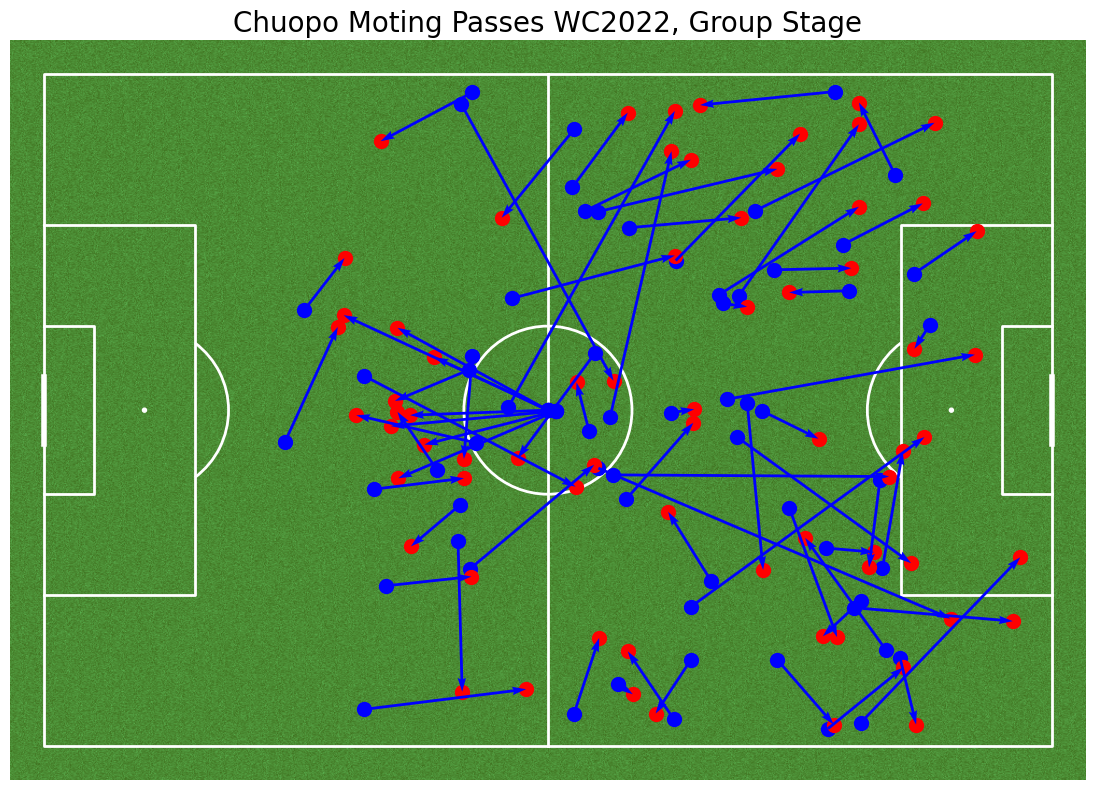

In [20]:
# Set the pitch dimensions
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

# Create a figure
fig, ax = pitch.draw()

# Plot the start and end locations
pitch.scatter(filtered.x_start, filtered.y_start, s=100, c='blue', ax=ax)
pitch.scatter(filtered.x_end, filtered.y_end, s=100, c='red', ax=ax)

# Plot the pass lines
for i in range(len(filtered)):
    pitch.arrows(filtered.x_start[i], filtered.y_start[i], filtered.x_end[i], filtered.y_end[i], width=2, color='blue', ax=ax)

# Add a title
ax.set_title('Chuopo Moting Passes WC2022, Group Stage', fontsize=20)

# Show the plot
fig.set_size_inches(12, 8)
fig.tight_layout()
fig.show()

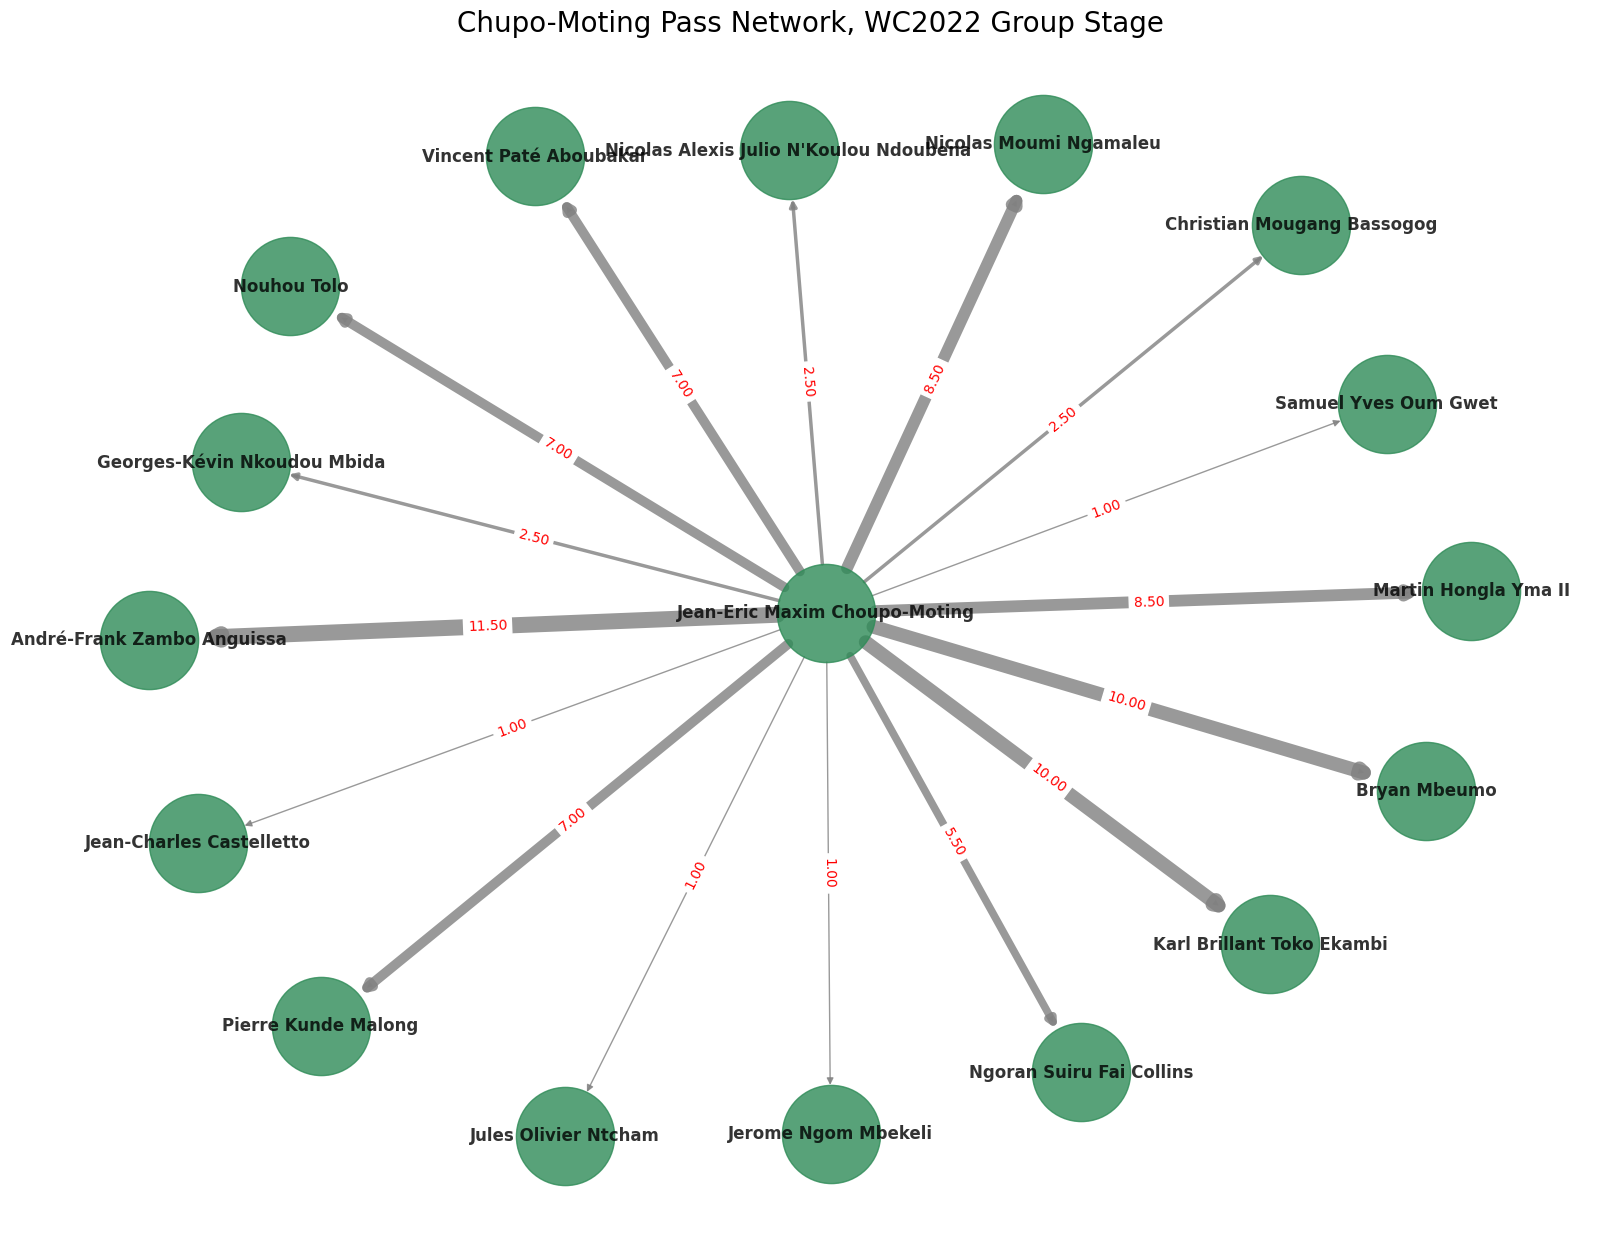

In [21]:
# Plot a pass network for Chupo-Moting
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for i in range(len(filtered)):
    passer = filtered['player_name'][i]
    recipient = filtered['pass_recipient_name'][i]
    if pd.notna(passer) and pd.notna(recipient):
        if G.has_edge(passer, recipient):
            G[passer][recipient]['weight'] += 1.5
        else:
            G.add_edge(passer, recipient, weight=1)

# Set the node positions
pos = nx.spring_layout(G)

# Draw the network
plt.figure(figsize=(16, 12))
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='seagreen', font_size=12, font_weight='bold', edge_color='gray', width=weights, alpha=0.8)

# Normalize and print the weights
normalized_weights = [weight / max(weights) for weight in weights]

# Add edge labels with normalized weights
edge_labels = {(edge[0], edge[1]): f'{weights[i]:.2f}' for i, edge in enumerate(edges)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Chupo-Moting Pass Network, WC2022 Group Stage', fontsize=20)
plt.tight_layout()
plt.show()
